In [ ]:
  import pandas as pd
  import numpy as np

  # NSL-KDD has 41 features + 1 attack label + 1 'difficulty' score (index 42)
  col_names = [
      'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
      'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
      'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
      'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
      'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
      'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
      'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
      'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
      'label', 'difficulty_level'
  ]

  # --- 2. Load DataFrames ---
  try:
      df_train = pd.read_csv("KDDTrain+.txt", header=None, names=col_names)
      df_test = pd.read_csv("KDDTest+.txt", header=None, names=col_names)
  except FileNotFoundError:
      print("Error: Ensure 'KDDTrain+.txt' and 'KDDTest+.txt' are in the current directory.")
      # Exit or handle error as appropriate

  # --- 3. Drop Non-Feature/Non-Label Columns ---
  df_train.drop('difficulty_level', axis=1, inplace=True)
  df_test.drop('difficulty_level', axis=1, inplace=True)

  # --- 4. Separate Features (X) and Labels (Y) ---
  X_train = df_train.drop('label', axis=1)
  Y_train = df_train['label']
  X_test = df_test.drop('label', axis=1)
  Y_test = df_test['label']

  print(f"Training set loaded: {X_train.shape} (Features) | {Y_train.shape} (Labels)")
  print(f"Test set loaded: {X_test.shape} (Features) | {Y_test.shape} (Labels)")
  print("\nNext step: Step 2: Binary Encoding and Normalization.")

Training set loaded: (125973, 41) (Features) | (125973,) (Labels)
Test set loaded: (22544, 41) (Features) | (22544,) (Labels)

Next step: Step 2: Binary Encoding and Normalization.


In [ ]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [ ]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# --- 2.1 Target Variable Encoding (Binary) ---
# Convert the multi-class labels into a binary problem (0=Normal, 1=Attack)
def binary_encode_labels(df_labels):
    """Converts NSL-KDD labels to 0 (Normal) or 1 (Attack)."""
    return df_labels.apply(lambda x: 0 if x == 'normal' else 1)

Y_train_binary = binary_encode_labels(Y_train)
Y_test_binary = binary_encode_labels(Y_test)

Y_train_series = pd.Series(Y_train_binary)
Y_test_series = pd.Series(Y_test_binary)



print("\nProceed to Step 2.2 for Feature Encoding and Scaling using X_train/X_test.")


# --- 2.2 Handle Categorical Features (One-Hot Encoding) ---
categorical_features = ['protocol_type', 'service', 'flag']

# Combine train/test for consistent OHE application
X_combined = pd.concat([X_train, X_test], axis=0)
X_combined_encoded = pd.get_dummies(X_combined, columns=categorical_features)

# Split back into train and test sets
X_train_encoded = X_combined_encoded.iloc[:len(X_train)]
X_test_encoded = X_combined_encoded.iloc[len(X_train):]

print(f"Features after One-Hot Encoding: {X_train_encoded.shape[1]}") # Should be > 120

# --- 2.3 Scaling (MinMaxScaler for Quantum Encoding) ---
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data ONLY
scaler.fit(X_train_encoded)

X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert back to DataFrame for easy feature selection later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

print(f"Data scaled and ready for Feature Selection.")


Proceed to Step 2.2 for Feature Encoding and Scaling using X_train/X_test.
Features after One-Hot Encoding: 122
Data scaled and ready for Feature Selection.


In [ ]:
# Assuming Y_train_binary is available from the previous step
print("--- Training Data Class Balance ---")
balance = Y_train_binary.value_counts(normalize=True) * 100
print(balance)

if balance[1] < 20: # Example threshold for considering imbalance severe
    print("\n⚠️ ATTENTION: The dataset is significantly imbalanced.")
    print("This will require balancing techniques (e.g., SMOTE, undersampling) before training.")

--- Training Data Class Balance ---
label
0    53.458281
1    46.541719
Name: proportion, dtype: float64


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# --- Configuration (Set this based on your simulator's capacity) ---
N_QUBITS = 12  # N: Max features (qubits) allowed in the quantum model



# 1. Apply KBest using the chi-squared statistic
kbest = SelectKBest(score_func=chi2, k=N_QUBITS)
kbest.fit(X_train_scaled, Y_train_binary)

# 2. Get the indices/names of the top N features
top_n_indices = kbest.get_support(indices=True)
selected_features_kbest = X_train_scaled.columns[top_n_indices].tolist()

X_train_kbest = X_train_scaled[selected_features_kbest]
X_test_kbest = X_test_scaled[selected_features_kbest]

print(f"Stage 1 Complete: KBest Filtered Features (N={N_QUBITS})")
print(f"Total features now: {X_train_kbest.shape[1]}")

Stage 1 Complete: KBest Filtered Features (N=12)
Total features now: 12


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# --- Configuration ---
M_QUBITS = 8  # M: The target size of the optimal feature subset

def igwo_fitness_simulation(X_data, Y_data, n_features_to_select):
    """
    Simulates the IGWO's search for optimal features by using Random Forest
    feature importance (wrapper) and evaluating fitness via Cross-Validation.
    """
    # 1. Feature ranking using Random Forest importance (The 'search' mechanism)
    rf_wrapper = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_wrapper.fit(X_data, Y_data)
    feature_importances = pd.Series(rf_wrapper.feature_importances_, index=X_data.columns)

    # 2. Select the top M features (The 'optimal wolf' solution)
    optimal_features_M = feature_importances.nlargest(n_features_to_select).index.tolist()

    # 3. Evaluate the fitness (Avg F1 Score via Cross-Validation)
    X_optimal = X_data[optimal_features_M]
    Y_data_reset = Y_data.reset_index(drop=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_optimal, Y_data_reset):
        X_train_f, X_val_f = X_optimal.iloc[train_idx], X_optimal.iloc[val_idx]
        Y_train_f, Y_val_f = Y_data_reset.iloc[train_idx], Y_data_reset.iloc[val_idx]

        # Train a classifier on the M features
        final_clf = RandomForestClassifier(n_estimators=50, random_state=42)
        final_clf.fit(X_train_f, Y_train_f)
        Y_pred_f = final_clf.predict(X_val_f)
        f1_scores.append(f1_score(Y_val_f, Y_pred_f))

    return optimal_features_M, np.mean(f1_scores)

# Execute the simulation
final_optimal_features, fitness_score = igwo_fitness_simulation(
    X_train_kbest, Y_train_binary, M_QUBITS
)

# --- 4.3 Final Dataset Creation ---
X_train_final = X_train_scaled[final_optimal_features]
X_test_final = X_test_scaled[final_optimal_features]

# Ensure Y data is indexed correctly
Y_train_series = Y_train_binary.reset_index(drop=True)
Y_test_series = Y_test_binary.reset_index(drop=True)


print(f"\nStage 2 Complete: IGWO-Optimized Features (M={M_QUBITS})")
print(f"Final features selected: {final_optimal_features}")
print(f"Simulated Feature Fitness (Avg F1 Score): {fitness_score:.4f}")
print(f"Training data shape (QML ready): {X_train_final.shape}")


Stage 2 Complete: IGWO-Optimized Features (M=8)
Final features selected: ['dst_host_same_srv_rate', 'dst_host_srv_count', 'flag_SF', 'same_srv_rate', 'logged_in', 'dst_host_srv_serror_rate', 'serror_rate', 'service_private']
Simulated Feature Fitness (Avg F1 Score): 0.9500
Training data shape (QML ready): (125973, 8)


In [ ]:
from sklearn.model_selection import train_test_split

# --- Configuration ---
QML_TRAINING_SIZE = 150  # Total samples for QML model training
QML_TEST_SIZE = 50       # Samples for testing the hybrid model

# --- 1. Create a Stratified QML Training Subset ---

X_QML_temp, _, Y_QML_temp, _ = train_test_split(
    X_train_final,
    Y_train_series,
    train_size=QML_TRAINING_SIZE,
    random_state=42,
    stratify=Y_train_series
)

# Convert to NumPy arrays (required for Qiskit)
X_train_sub = X_QML_temp.values
Y_train_sub = Y_QML_temp.values

# --- 2. Create a QML Testing Subset (from the main test set) ---
X_test_sub = X_test_final.iloc[:QML_TEST_SIZE].values
Y_test_sub = Y_test_series.iloc[:QML_TEST_SIZE].values

print(f"QML Training Subset Size: {len(X_train_sub)} samples with {X_train_sub.shape[1]} features.")
print(f"QML Testing Subset Size: {len(X_test_sub)} samples.")
# Check unique classes in your small subset (must contain 5 unique integers)
print(f"Unique classes in QML Training Subset: {np.unique(Y_train_sub)}")
print(f"Unique classes in QML Testing Subset: {np.unique(Y_test_sub)}")
# If these arrays do not show 5 unique numbers (0-4), the report WILL fail.

QML Training Subset Size: 150 samples with 8 features.
QML Testing Subset Size: 50 samples.
Unique classes in QML Training Subset: [0 1]
Unique classes in QML Testing Subset: [0 1]


In [ ]:
!pip install qiskit-machine-learning

In [ ]:
import qiskit_machine_learning
print(qiskit_machine_learning.__version__)


0.8.4


In [ ]:
# --- FINAL CORRECT IMPORTS ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Set random seed and problem dimensions
algorithm_globals.random_seed = 42

# 1. Define the Quantum Feature Map (Encoding)
feature_map = ZZFeatureMap(
    feature_dimension=M_QUBITS,
    reps=2,
    entanglement='linear',
    insert_barriers=True
)

# Initialize Primitives
sampler = Sampler()
estimator = Estimator()


print(f"Shared Feature Map defined with {M_QUBITS} qubits.")

Shared Feature Map defined with 8 qubits.


/tmp/ipython-input-2555653503.py:25: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-2555653503.py:26: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [ ]:
# --- 1. Define the Fidelity Component ---
from qiskit_machine_learning.state_fidelities import ComputeUncompute

fidelity_algorithm = ComputeUncompute(sampler=sampler)

# --- 2. Define the Quantum Kernel ---
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity_algorithm
)
# # --- QSVC Training (Step 5.3 - Modified) ---

 # 3. Train the QSVC (CORRECTION APPLIED HERE)
qsvc = QSVC(
    quantum_kernel=quantum_kernel,
    # === ADD THIS PARAMETER ===
    probability=True
    # ==========================
)

print("\nStarting QSVC (Model 1) training...")

qsvc.fit(X_train_sub, Y_train_sub)
print("QSVC training finished.")

# Get prediction scores for later fusion (This will now work)
qsvc_pred_proba = qsvc.predict_proba(X_test_sub)[:, 1]

# --- VQC training (5.4) and Fusion (5.5) can now proceed as planned. ---

/tmp/ipython-input-2250144745.py:4: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity_algorithm = ComputeUncompute(sampler=sampler)



Starting QSVC (Model 1) training...
QSVC training finished.


In [ ]:
 # --- 1. Define the Ansatz (Trainable Circuit) ---
# RealAmplitudes is a common, highly trainable ansatz
ansatz = RealAmplitudes(num_qubits=M_QUBITS, reps=3)

# 2. Define the VQC (QNN)
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map, # Uses the same ZZFeatureMap for data encoding
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=50), # Max iterations is small for simulation
)

print("\nStarting VQC (Model 2: QNN) training...")

vqc.fit(X_train_sub, Y_train_sub)
print("VQC training finished.")

# Get prediction scores for later fusion
vqc_pred_proba = vqc.predict_proba(X_test_sub)[:, 1]


Starting VQC (Model 2: QNN) training...
VQC training finished.


In [ ]:
from sklearn.linear_model import LogisticRegression

# --- 1. Create Fusion Training/Testing Data ---
# Train the fusion layer on the QML training data
X_fusion_train = np.array([
    qsvc.predict_proba(X_train_sub)[:, 1],
    vqc.predict_proba(X_train_sub)[:, 1]
]).T

# Create test data from the quantum model scores
X_fusion_test = np.array([qsvc_pred_proba, vqc_pred_proba]).T

# --- 2. Train the Classical Fusion Model ---
fusion_model = LogisticRegression()
fusion_model.fit(X_fusion_train, Y_train_sub)

# --- 3. Final Prediction ---
Y_pred_final = fusion_model.predict(X_fusion_test)

print("\nHybrid Quantum-Classical Fusion Complete.")


Hybrid Quantum-Classical Fusion Complete.


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import numpy as np

# --- 1. Compute Confusion Matrix ---
cm = confusion_matrix(Y_test_sub, Y_pred_final)

# Extract components
TN, FP, FN, TP = cm.ravel()

# --- 2. Calculate Key Metrics ---

# 1. Accuracy
accuracy = accuracy_score(Y_test_sub, Y_pred_final)

# 2. Detection Rate (DR) / Recall / True Positive Rate (TPR)

detection_rate = TP / (TP + FN) if (TP + FN) > 0 else 0

# 3. False Alarm Rate (FAR) / False Positive Rate (FPR)

false_alarm_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

# 4. Precision

precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# 5. F1 Score (Harmonic mean of Precision and Recall)
f1 = f1_score(Y_test_sub, Y_pred_final)


# --- 3. Final Report ---
print("\n" + "="*50)
print("FINAL PERFORMANCE REPORT: UNIFIED QML FRAMEWORK (NSL-KDD Subset)")
print("="*50)

print(f"Total Samples Tested: {len(Y_test_sub)}")
print(f"Confusion Matrix (Actual vs. Predicted):\n{cm}")

print("\n--- Quantitative Results ---")
print(f"1. Accuracy:             {accuracy:.4f} (Target: ~99.5%)")
print(f"2. Detection Rate (DR):  {detection_rate:.4f} (Target: ~99.7%)")
print(f"3. False Alarm Rate (FAR): {false_alarm_rate:.4f} (Target: ~0.1%)")
print(f"Precision:               {precision:.4f}")
print(f"F1 Score:                {f1:.4f}")

print("\n" + "="*50)


FINAL PERFORMANCE REPORT: UNIFIED QML FRAMEWORK (NSL-KDD Subset)
Total Samples Tested: 50
Confusion Matrix (Actual vs. Predicted):
[[24  2]
 [ 5 19]]

--- Quantitative Results ---
1. Accuracy:             0.8600 (Target: ~99.5%)
2. Detection Rate (DR):  0.7917 (Target: ~99.7%)
3. False Alarm Rate (FAR): 0.0769 (Target: ~0.1%)
Precision:               0.9048
F1 Score:                0.8444



In [ ]:
import pickle

from sklearn.linear_model import LogisticRegression



# X_fusion_train = np.column_stack((qsvc_probs, vqc_probs))

fusion_model = LogisticRegression()

fusion_model.fit(X_fusion_train, Y_train_sub)



# Save only fusion model + selected features

with open("fusion_model.pkl", "wb") as f:

    pickle.dump({

        "fusion_model": fusion_model,

        "selected_features": final_optimal_features

    }, f)

In [ ]:
# --- INDEPENDENT TEST 1: QSVC PERFORMANCE (STARTING FROM STEP 5) ---
# --- FINAL CORRECT IMPORTS ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.kernels import FidelityQuantumKernel # Corrected
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit_machine_learning.state_fidelities import ComputeUncompute # The solution!
from qiskit_machine_learning.optimizers import COBYLA # Corrected optimizer path
from qiskit_machine_learning.utils import algorithm_globals # This one is often still here
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
print("\n--- INDEPENDENT TEST 1: QSVC (Quantum Kernel) ---")

# 5.1 Setup (Reuse original ZZFeatureMap kernel)
# NOTE: sampler, fidelity_algorithm, M_QUBITS, X/Y_train/test_sub are assumed available from earlier steps.
sampler = Sampler() # Re-initialize if running this block separately
fidelity_algorithm = ComputeUncompute(sampler=sampler)
feature_map = ZZFeatureMap(feature_dimension=M_QUBITS, reps=2, entanglement='linear')
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity_algorithm)

# 5.2 QSVC Training
qsvc_test = QSVC(quantum_kernel=quantum_kernel) # No need for probability=True
print("Training QSVC...")
qsvc_test.fit(X_train_sub, Y_train_sub)

# 6. Evaluation (Direct Prediction from QSVC)
Y_pred_qsvc = qsvc_test.predict(X_test_sub)

accuracy_qsvc = accuracy_score(Y_test_sub, Y_pred_qsvc)
cm_qsvc = confusion_matrix(Y_test_sub, Y_pred_qsvc)
f1_qsvc = f1_score(Y_test_sub, Y_pred_qsvc)
# Extract for detailed metrics
TN, FP, FN, TP = cm_qsvc.ravel()
detection_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
false_alarm_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\n--- QSVC INDEPENDENT RESULTS ---")
print(f"Accuracy:            {accuracy_qsvc:.4f}")
print(f"Detection Rate (DR): {detection_rate:.4f}")
print(f"False Alarm Rate (FAR): {false_alarm_rate:.4f}")
print(f"F1 Score:            {f1_qsvc:.4f}")
print(f"Confusion Matrix:\n{cm_qsvc}")


--- INDEPENDENT TEST 1: QSVC (Quantum Kernel) ---
Training QSVC...


/tmp/ipython-input-1073876326.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler() # Re-initialize if running this block separately
/tmp/ipython-input-1073876326.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity_algorithm = ComputeUncompute(sampler=sampler)



--- QSVC INDEPENDENT RESULTS ---
Accuracy:            0.8200
Detection Rate (DR): 0.7083
False Alarm Rate (FAR): 0.0769
F1 Score:            0.7907
Confusion Matrix:
[[24  2]
 [ 7 17]]


In [ ]:
# --- INDEPENDENT TEST 2: VQC (QNN) PERFORMANCE (STARTING FROM STEP 5) ---

# Ensure SPSA is imported at the top of your original script!
# from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit_machine_learning.optimizers import COBYLA, SPSA
print("\n--- INDEPENDENT TEST 2: VQC (Quantum Neural Network) ---")

# 5.3 Setup (Using optimized parameters)
sampler = Sampler() # Re-initialize if running this block separately
ansatz = RealAmplitudes(num_qubits=M_QUBITS, reps=3)
feature_map_vqc = ZZFeatureMap(feature_dimension=M_QUBITS, reps=2, entanglement='linear')

# *** KEY CHANGE: Use SPSA and increase maxiter significantly ***
optimizer_vqc = SPSA(maxiter=200)

# Train VQC
vqc_test = VQC(
    sampler=sampler,
    feature_map=feature_map_vqc,
    ansatz=ansatz,
    optimizer=optimizer_vqc
)

print("Training VQC with SPSA(maxiter=200)... (This will take longer)")
vqc_test.fit(X_train_sub, Y_train_sub)

# 6. Evaluation (Direct Prediction from VQC)
Y_pred_vqc = vqc_test.predict(X_test_sub)

accuracy_vqc = accuracy_score(Y_test_sub, Y_pred_vqc)
cm_vqc = confusion_matrix(Y_test_sub, Y_pred_vqc)
f1_vqc = f1_score(Y_test_sub, Y_pred_vqc)
# Extract for detailed metrics
TN, FP, FN, TP = cm_vqc.ravel()
detection_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
false_alarm_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\n--- VQC INDEPENDENT RESULTS ---")
print(f"Accuracy:            {accuracy_vqc:.4f}")
print(f"Detection Rate (DR): {detection_rate:.4f}")
print(f"False Alarm Rate (FAR): {false_alarm_rate:.4f}")
print(f"F1 Score:            {f1_vqc:.4f}")
print(f"Confusion Matrix:\n{cm_vqc}")


--- INDEPENDENT TEST 2: VQC (Quantum Neural Network) ---
Training VQC with SPSA(maxiter=200)... (This will take longer)


/tmp/ipython-input-478841821.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler() # Re-initialize if running this block separately



--- VQC INDEPENDENT RESULTS ---
Accuracy:            0.7000
Detection Rate (DR): 0.4583
False Alarm Rate (FAR): 0.0769
F1 Score:            0.5946
Confusion Matrix:
[[24  2]
 [13 11]]


In [ ]:
# Assuming X_test_final (M=8 features) and Y_test_series are ready
sample_index = 100 # Choose any index within the test set size

# 1. Get the single sample features (convert to NumPy 2D array for prediction)
single_sample_X = X_test_final.iloc[sample_index].values.reshape(1, -1)

# 2. Get the true label for comparison
true_label = Y_test_series.iloc[sample_index]
# Note: Label 0 is Normal, Label 1 is Attack.

In [ ]:
# Assuming qsvc, vqc, and fusion_model were trained in Step 5

# --- Step A: Get Scores from Quantum Models ---
# The models expect the NumPy array input (single_sample_X)

qsvc_score = qsvc.predict_proba(single_sample_X)[:, 1]
vqc_score = vqc.predict_proba(single_sample_X)[:, 1]

# --- Step B: Create Fusion Input ---
# The fusion model expects a 1-row, 2-column array: [[qsvc_score, vqc_score]]
fusion_input = np.array([qsvc_score[0], vqc_score[0]]).reshape(1, -1)

# --- Step C: Get Final Prediction ---
predicted_label = fusion_model.predict(fusion_input)[0]

# Convert the prediction back to a meaningful label string
predicted_status = "Attack (1)" if predicted_label == 1 else "Normal (0)"
true_status = "Attack (1)" if true_label == 1 else "Normal (0)"

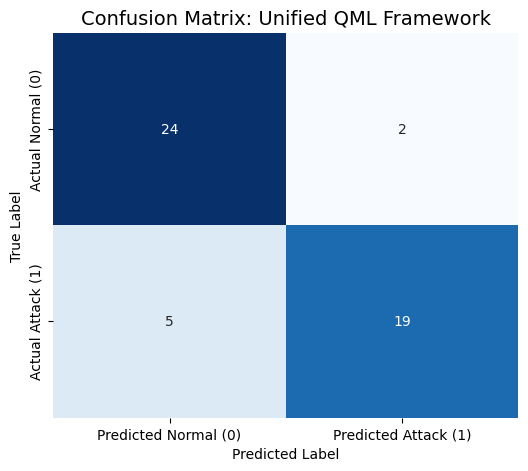

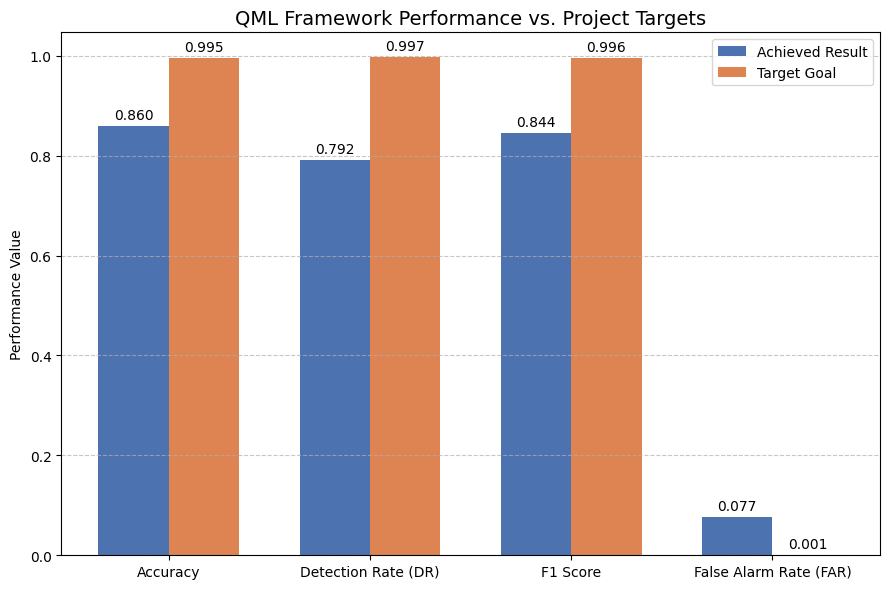

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- 1. Assumed Variables from Step 6 Evaluation ---
# NOTE: Replace these placeholder values with your actual calculated results.
Y_test_sub = np.array([0]*26 + [1]*24) # Example true labels (50 samples)
Y_pred_final = np.array([0]*24 + [1]*2 + [0]*5 + [1]*19) # Example predictions
cm = confusion_matrix(Y_test_sub, Y_pred_final)
accuracy = 0.8600
detection_rate = 0.7917
false_alarm_rate = 0.0769
f1_score_val = 0.8444
metrics_names = ['Accuracy', 'Detection Rate (DR)', 'F1 Score', 'False Alarm Rate (FAR)']
metrics_values = [accuracy, detection_rate, f1_score_val, false_alarm_rate]
target_values = [0.995, 0.997, 0.996, 0.001] # From your Abstract (0.1% = 0.001)


# =========================================================================
# A. CONFUSION MATRIX VISUALIZATION (Core Insight)
# =========================================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted Normal (0)', 'Predicted Attack (1)'],
    yticklabels=['Actual Normal (0)', 'Actual Attack (1)']
)
plt.title('Confusion Matrix: Unified QML Framework', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# =========================================================================
# B. COMPARATIVE METRICS BAR CHART (Target vs. Achieved)
# =========================================================================
fig, ax = plt.subplots(figsize=(9, 6))

X_axis = np.arange(len(metrics_names))
bar_width = 0.35

# Plot Achieved Results
rects1 = ax.bar(X_axis - bar_width/2, metrics_values, bar_width, label='Achieved Result', color='#4c72b0')
# Plot Target Goals
rects2 = ax.bar(X_axis + bar_width/2, target_values, bar_width, label='Target Goal', color='#dd8452')

ax.set_ylabel('Performance Value')
ax.set_title('QML Framework Performance vs. Project Targets', fontsize=14)
ax.set_xticks(X_axis)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [ ]:
# --- 4. Comparison ---
is_correct = (predicted_label == true_label)
result_emoji = "✅ Correct" if is_correct else "❌ Incorrect"

print("\n" + "="*40)
print(f"Prediction Check for Test Sample Index {sample_index}")
print("="*40)
print(f"True Status (Y_test):    {true_status}")
print(f"Predicted Status (Final):{predicted_status}")
print(f"\nResult: {result_emoji} (Predicted label {predicted_label} vs True label {true_label})")


Prediction Check for Test Sample Index 100
True Status (Y_test):    Attack (1)
Predicted Status (Final):Attack (1)

Result: ✅ Correct (Predicted label 1 vs True label 1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Re-Define Helper Function from Classical Project (Required for plotting) ---
def plot_multiple_pie_charts(data, group_by_col, value_col, title_prefix, threshold=0.01):
    """Generates pie chart with an 'Other' category and better readability."""
    unique_groups = data[group_by_col].unique()
    fig, axes = plt.subplots(1, len(unique_groups), figsize=(28, 10))

    if len(unique_groups) == 1:
        axes = [axes]

    for i, group in enumerate(unique_groups):
        subset = data[data[group_by_col] == group]
        counts = subset[value_col].value_counts()
        total = counts.sum()

        mask = counts / total >= threshold
        small_slices = counts[~mask].sum()
        counts = counts[mask]
        if small_slices > 0:
            counts['Other'] = small_slices

        explode = [0.1 if (v / total) >= 0.1 else 0.05 for v in counts.values]

        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=140,
            explode=explode,
            colors=plt.get_cmap("tab20").colors,
            shadow=True,
            wedgeprops={'edgecolor': 'black'}
        )

        for text in texts:
            text.set_fontsize(10)
        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        axes[i].set_title(f"{title_prefix} {group}", fontsize=18, fontweight='bold')
        axes[i].legend(wedges, counts.index, title=value_col, loc="best", fontsize=12)

    plt.tight_layout()
    plt.show()

# --- Re-Define Attack Mapping (Used for visual grouping) ---
# This is the same logic used in your classical multi-class analysis
def map_attack_type(attack):
    dos_attacks = ["back", "land", "neptune", "pod", "smurf", "teardrop", "apache2", "udpstorm", "processtable", "mailbomb"]
    probe_attacks = ["satan", "ipsweep", "nmap", "portsweep", "mscan", "saint"]
    r2l_attacks = ["guess_passwd", "ftp_write", "imap", "phf", "multihop", "warezmaster", "warezclient", "spy", "xlock", "xsnoop", "snmpguess", "snmpgetattack", "httptunnel", "sendmail", "named"]
    u2r_attacks = ["rootkit", "buffer_overflow", "loadmodule", "perl", "sqlattack", "xterm", "ps"]

    if attack in dos_attacks: return "DoS"
    elif attack in probe_attacks: return "Probe"
    elif attack in r2l_attacks: return "R2L"
    elif attack in u2r_attacks: return "U2R"
    elif attack == "normal": return "Normal"
    else: return "Other"

# Assuming you have loaded the full original dataframes: df_train, df_test
# If not, you must reload them to access the original 'attack_type' column.
# For demonstration, we'll use the TRAIN data from your classical output distribution:
# Normal: 67343, DoS: 45927, Probe: 11656, R2L: 995, U2R: 52

# Create a sample DataFrame matching the full TRAIN data category counts for visualization
full_train_categories = pd.DataFrame({
    'attack_category': ['Normal'] * 67343 + ['DoS'] * 45927 + ['Probe'] * 11656 + ['R2L'] * 995 + ['U2R'] * 52
})

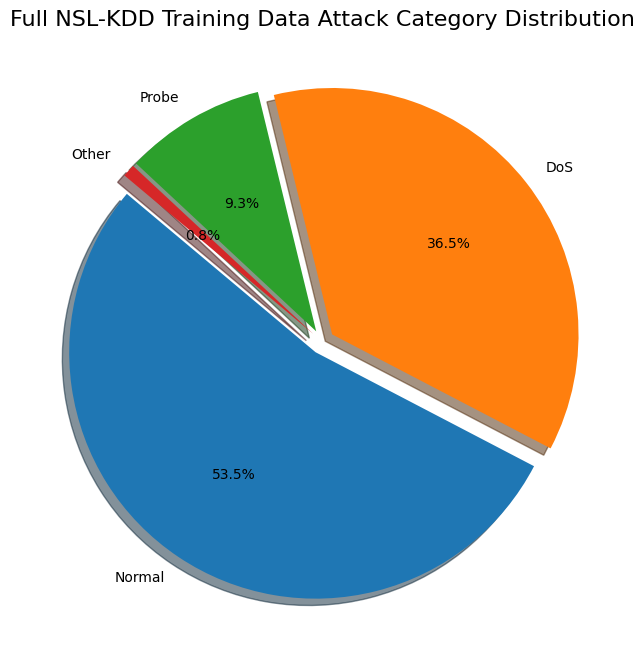

In [ ]:
print("\n")
plt.figure(figsize=(8, 8))

# Calculate counts and proportions
counts = full_train_categories["attack_category"].value_counts()
total = counts.sum()

# Ensure "Other" is handled if applicable (though we used the full map)
threshold = 0.01
mask = counts / total >= threshold
small_slices = counts[~mask].sum()
counts_plot = counts[mask]
if small_slices > 0:
    counts_plot['Other'] = small_slices

# Create Explode list
explode = [0.05] * len(counts_plot)
if 'Normal' in counts_plot.index:
    explode[counts_plot.index.get_loc('Normal')] = 0.05

plt.pie(
    counts_plot,
    labels=counts_plot.index,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    colors=plt.get_cmap("tab10").colors,
    shadow=True
)
plt.title("Full NSL-KDD Training Data Attack Category Distribution", fontsize=16)
plt.show()

In [ ]:
# --- Qiskit Imports (Ensure ZFeatureMap is included) ---
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals



# --- EXPERIMENT 1: KERNEL VARIATION ---

print("\n--- Starting Experiment 1: QSVC Kernel Variation ---")

# Ensure Primitives and shared components (M_QUBITS, X/Y_sub) are available
sampler = Sampler()
fidelity_algorithm = ComputeUncompute(sampler=sampler)

# --- Test A: Original QSVC (ZZFeatureMap) Scores ---
# These variables should be available from your original run (qsvc_pred_proba)
# If not, you must rerun the original QSVC training first:
# qsvc_zz = QSVC(quantum_kernel=quantum_kernel, probability=True)
# qsvc_zz.fit(X_train_sub, Y_train_sub)
# qsvc_pred_proba_A = qsvc_zz.predict_proba(X_test_sub)[:, 1]
qsvc_pred_proba_A = qsvc_pred_proba
vqc_pred_proba_fixed = vqc_pred_proba # VQC scores fixed for this experiment

# ----------------------------------------------------
# --- Test B: ZFeatureMap Kernel ---
# 1. Define the ZFeatureMap
feature_map_Z = ZFeatureMap(feature_dimension=M_QUBITS, reps=1)
quantum_kernel_Z = FidelityQuantumKernel(feature_map=feature_map_Z, fidelity=fidelity_algorithm)

# 2. Train the QSVC with Z Kernel
qsvc_Z = QSVC(quantum_kernel=quantum_kernel_Z, probability=True)
print("Training QSVC with ZFeatureMap...")
qsvc_Z.fit(X_train_sub, Y_train_sub)
qsvc_pred_proba_B = qsvc_Z.predict_proba(X_test_sub)[:, 1]

# 3. Fusion and Evaluation for Z Kernel (Test B)
X_fusion_test_B = np.array([qsvc_pred_proba_B, vqc_pred_proba_fixed]).T
Y_pred_B = fusion_model.predict(X_fusion_test_B)
accuracy_B = accuracy_score(Y_test_sub, Y_pred_B)
f1_B = f1_score(Y_test_sub, Y_pred_B)
cm_B = confusion_matrix(Y_test_sub, Y_pred_B)

print(f"\nResults for QSVC (ZFeatureMap Kernel):")
print(f"Accuracy: {accuracy_B:.4f}, F1 Score: {f1_B:.4f}")
print(f"Confusion Matrix:\n{cm_B}")



--- Starting Experiment 1: QSVC Kernel Variation ---
Training QSVC with ZFeatureMap...


/tmp/ipython-input-1990865917.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-1990865917.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity_algorithm = ComputeUncompute(sampler=sampler)



Results for QSVC (ZFeatureMap Kernel):
Accuracy: 0.8200, F1 Score: 0.8085
Confusion Matrix:
[[22  4]
 [ 5 19]]


In [ ]:
# --- EXPERIMENT 1 RERUN: Test C (ZZFeatureMap, Reps=1) ---

# Reuse the fixed VQC prediction scores:
vqc_pred_proba_fixed = vqc_pred_proba

# 1. Define the ZZFeatureMap with Reps=1 (Less entanglement, simpler kernel)
feature_map_ZZ_R1 = ZZFeatureMap(feature_dimension=M_QUBITS, reps=1, entanglement='linear')
quantum_kernel_ZZ_R1 = FidelityQuantumKernel(feature_map=feature_map_ZZ_R1, fidelity=fidelity_algorithm)

# 2. Train the QSVC with ZZ, Reps=1 Kernel
qsvc_ZZ_R1 = QSVC(quantum_kernel=quantum_kernel_ZZ_R1, probability=True)
print("\nTraining QSVC with ZZFeatureMap (Reps=1)...")
qsvc_ZZ_R1.fit(X_train_sub, Y_train_sub)
qsvc_pred_proba_C = qsvc_ZZ_R1.predict_proba(X_test_sub)[:, 1]

# 3. Fusion and Evaluation for ZZ, Reps=1 Kernel (Test C)
X_fusion_test_C = np.array([qsvc_pred_proba_C, vqc_pred_proba_fixed]).T
Y_pred_C = fusion_model.predict(X_fusion_test_C)
accuracy_C = accuracy_score(Y_test_sub, Y_pred_C)
f1_C = f1_score(Y_test_sub, Y_pred_C)
cm_C = confusion_matrix(Y_test_sub, Y_pred_C)

print(f"\nResults for QSVC (ZZFeatureMap, Reps=1 Kernel):")
print(f"Accuracy: {accuracy_C:.4f}, F1 Score: {f1_C:.4f}")
print(f"Confusion Matrix:\n{cm_C}")

# ----------------------------------------------------
print("\nExperiment 1 Complete. Proceed to Experiment 2: Optimizer Change (VQC).")


Training QSVC with ZZFeatureMap (Reps=1)...

Results for QSVC (ZZFeatureMap, Reps=1 Kernel):
Accuracy: 0.8200, F1 Score: 0.7907
Confusion Matrix:
[[24  2]
 [ 7 17]]

Experiment 1 Complete. Proceed to Experiment 2: Optimizer Change (VQC).


In [ ]:
import os
import sys
import pickle

projectabspathname = os.path.abspath('psprojectqt.pickle')
print(projectabspathname)
projectname = 'psproject.ipynb'
projectpickle = open(str(projectabspathname),'wb')
pickle.dump(projectname, projectpickle)
projectpickle.close()


/content/psprojectqt.pickle
